In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

DATA PREP


In [ ]:
import kagglehub

# Download latest version
data = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset-v2")

print("Path to dataset files:", data)

100%|██████████| 379M/379M [00:03<00:00, 103MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1


In [ ]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("uraninjo/augmented-alzheimer-mri-dataset-v2").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

DISPLAY THE IMAGES FROM DATASET

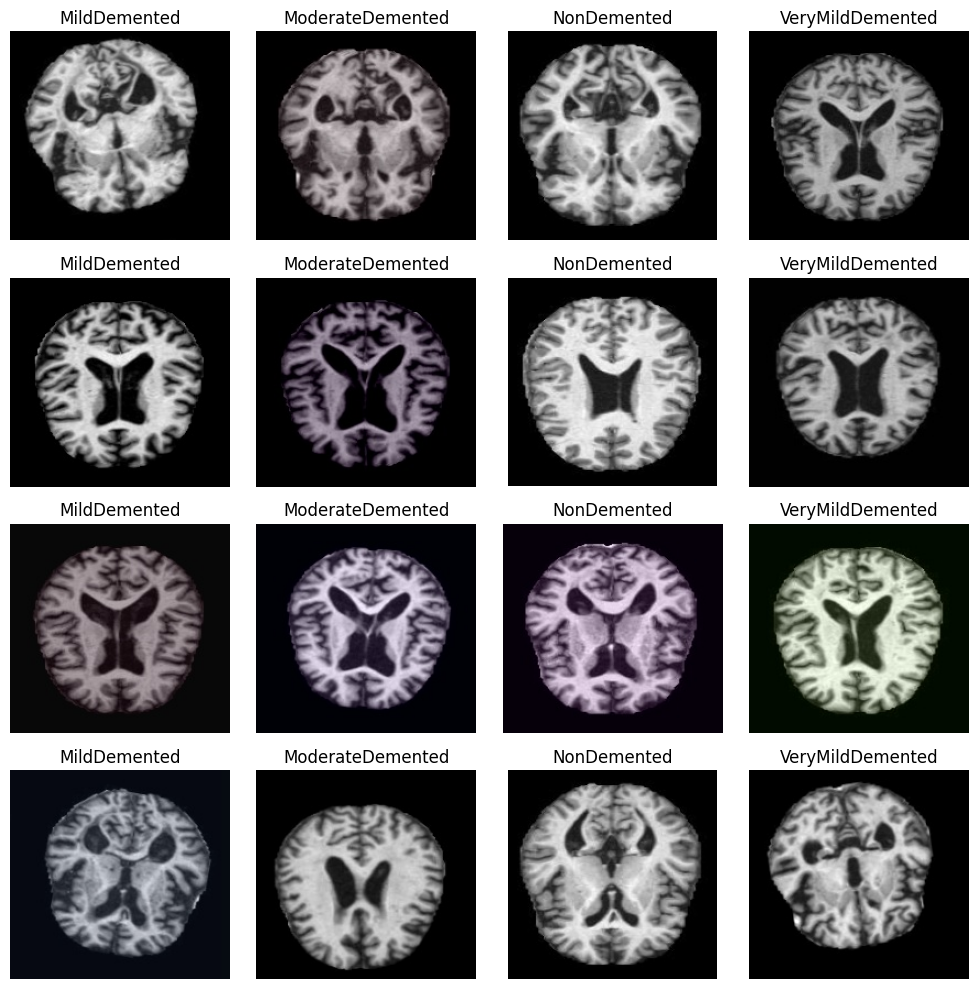

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the categories for classification
categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Initialize a figure with 4 rows and 4 columns (1 column per category)
fig, axes = plt.subplots(nrows=4, ncols=len(categories), figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

# Loop through each category and pick 4 images per category
for col, category in enumerate(categories):
    category_images = image_df[image_df['Label'] == category]

    # Select 4 random images for this category
    selected_images = category_images.sample(4)

    # Loop through the 4 images and display them in the correct column
    for row, (img_path, label) in enumerate(zip(selected_images['Filepath'], selected_images['Label'])):
        ax = axes[row, col]  # Set the axis for this image
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')  # Hide the axes for a cleaner look

plt.tight_layout()
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

In [ ]:
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 32308 images belonging to 1 classes.
Found 8076 images belonging to 1 classes.


CREATE AND COMPILE CNN MODEL


TRAIN THE MODEL

Found 32307 validated image filenames belonging to 4 classes.
Found 8077 validated image filenames belonging to 4 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,684 (358.14 KB)

 Trainable params: 91,684 (358.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 78s 74ms/step - accuracy: 0.3698 - loss: 1.2848 - val_accuracy: 0.5183 - val_loss: 1.0147
Epoch 2/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 76s 70ms/step - accuracy: 0.4947 - loss: 1.0728 - val_accuracy: 0.5710 - val_loss: 0.9004
Epoch 3/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 70s 69ms/step - accuracy: 0.5597 - loss: 0.9242 - val_accuracy: 0.6142 - val_loss: 0.8015
Epoch 4/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.5838 - loss: 0.8715 - val_accuracy: 0.6055 - val_loss: 0.8217
Epoch 5/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 71s 70ms/step - accuracy: 0.6007 - loss: 0.8369 - val_accuracy: 0.6242 - val_loss: 0.7824
Epoch 6/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.6116 - loss: 0.8123 - val_accuracy: 0.6391 - val_loss: 0.7242
Epoch 7/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - accuracy: 0.6248 - loss: 0.7906 - val_accuracy: 0.6489 - val_loss: 0.7161
Epoch 8/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 74s 73ms/step - accuracy: 0.6253 -

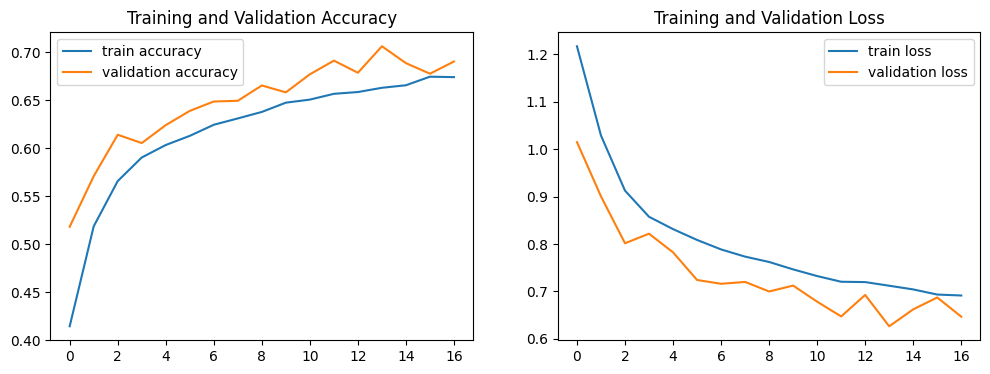

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# Download and load the dataset from Kaggle
import kagglehub
data = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset-v2")
image_dir = Path(data)

# Get file paths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

# Split into training and validation sets
train_df, val_df = train_test_split(image_df, test_size=0.2, stratify=image_df['Label'], random_state=42)

# Preprocessing: Image augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                             width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                             horizontal_flip=True, fill_mode="nearest")

train_images = datagen.flow_from_dataframe(train_df, x_col='Filepath', y_col='Label',
                                           target_size=(64, 64), class_mode='categorical', batch_size=32)

val_datagen = ImageDataGenerator(rescale=1./255)
validation_images = val_datagen.flow_from_dataframe(val_df, x_col='Filepath', y_col='Label',
                                                    target_size=(64, 64), class_mode='categorical', batch_size=32)

# Building the CNN model
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to avoid overfitting
    layers.Dense(4, activation='softmax')  # 4 categories for Alzheimer's progression
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_images, validation_data=validation_images, epochs=20,
                    callbacks=[early_stop])

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Save the trained model
model.save('alzheimers_detection_model.h5')

# Function for preprocessing and predicting new MRI images
from tensorflow.keras.preprocessing import image

def preprocess_and_predict(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch compatibility
    prediction = model.predict(img_array)
    return categories[np.argmax(prediction)]  # Return the predicted class


EVALUATE THE MODEL

In [ ]:
loss, accuracy = model.evaluate(validation_images)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6498 - loss: 0.7275
Validation Accuracy: 65.02%


PLOT TRAINING HISTORY

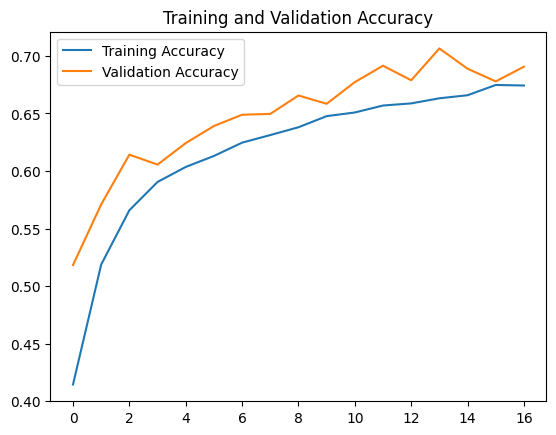

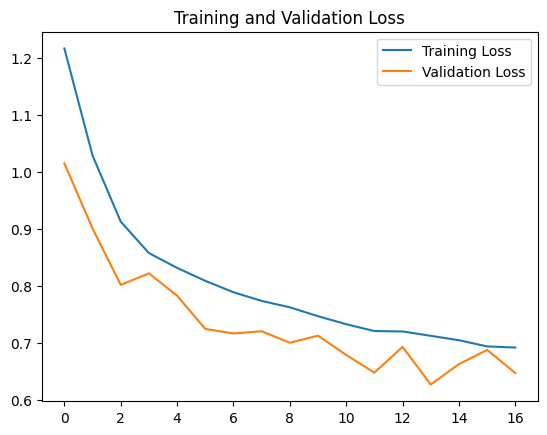

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on validation set
predictions = model.predict(validation_images)

# Get the predicted class labels
predicted_classes = np.argmax(predictions, axis=1)  # Choose the class with the highest probability
true_classes = validation_images.classes  # Get the true labels from the validation set


253/253 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


                  precision    recall  f1-score   support

    MildDemented       0.23      0.39      0.29      1971
ModerateDemented       0.17      0.16      0.17      1306
     NonDemented       0.32      0.23      0.27      2560
VeryMildDemented       0.29      0.20      0.24      2240

        accuracy                           0.25      8077
       macro avg       0.25      0.25      0.24      8077
    weighted avg       0.26      0.25      0.25      8077



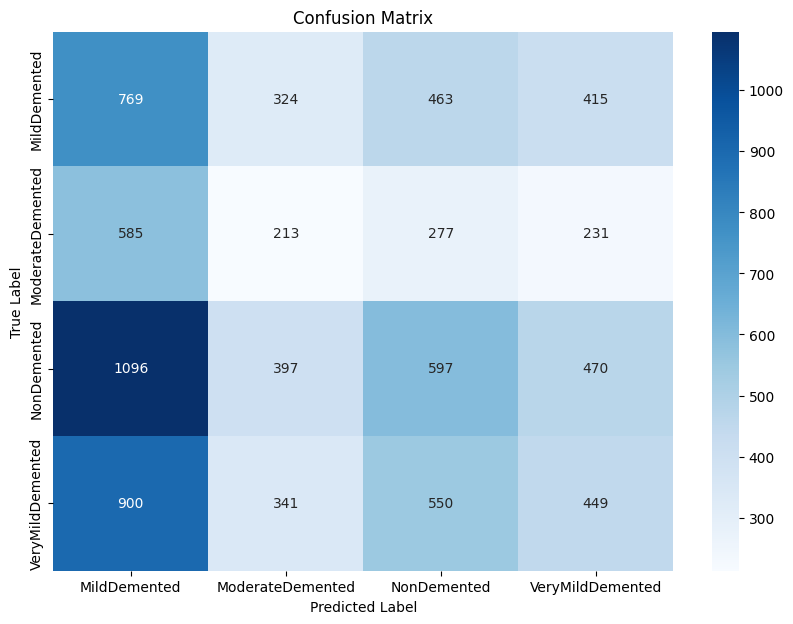

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=validation_images.class_indices.keys())
print(report)

# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_images.class_indices.keys(), yticklabels=validation_images.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
from sklearn.metrics import r2_score

#R^2: what percent of variance in dependent variables is explained by the model
# Use the one-hot encoded format of true classes for comparison
true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(validation_images.class_indices))

# Calculate R^2 score
r2 = r2_score(true_classes_one_hot, predictions)
print("R^2 Score:", r2)


R^2 Score: -0.46433973200857576


In [ ]:
# Extract true labels from the validation generator
true_labels = validation_images.labels

# Note: This will give you a numeric array of labels corresponding to the class indices.
# To get class names, use:
class_names = list(validation_images.class_indices.keys())  # Maps numeric labels to class names

# Get model predictions
predictions = model.predict(validation_images)
predicted_classes = predictions.argmax(axis=1)  # Convert probabilities to class indices


# Convert numeric labels to class names
true_labels_names = [class_names[label] for label in true_labels]
predicted_classes_names = [class_names[label] for label in predicted_classes]



253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


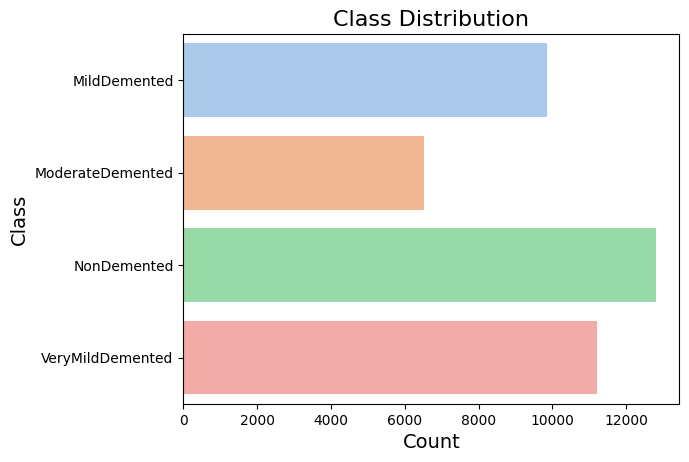

In [ ]:
import seaborn as sns

# Assuming `image_df` contains your dataset with a 'Label' column
sns.countplot(y='Label', data=image_df, palette='pastel')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.show()


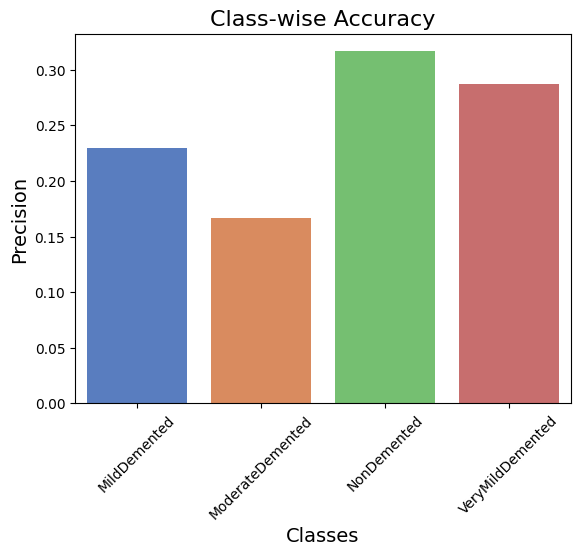

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_labels, predicted_classes, target_names=validation_images.class_indices.keys(), output_dict=True)

# Plot class-wise accuracy
class_accuracies = [report[label]['precision'] for label in validation_images.class_indices.keys()]
sns.barplot(x=list(validation_images.class_indices.keys()), y=class_accuracies, palette='muted')
plt.title('Class-wise Accuracy', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(rotation=45)
plt.show()


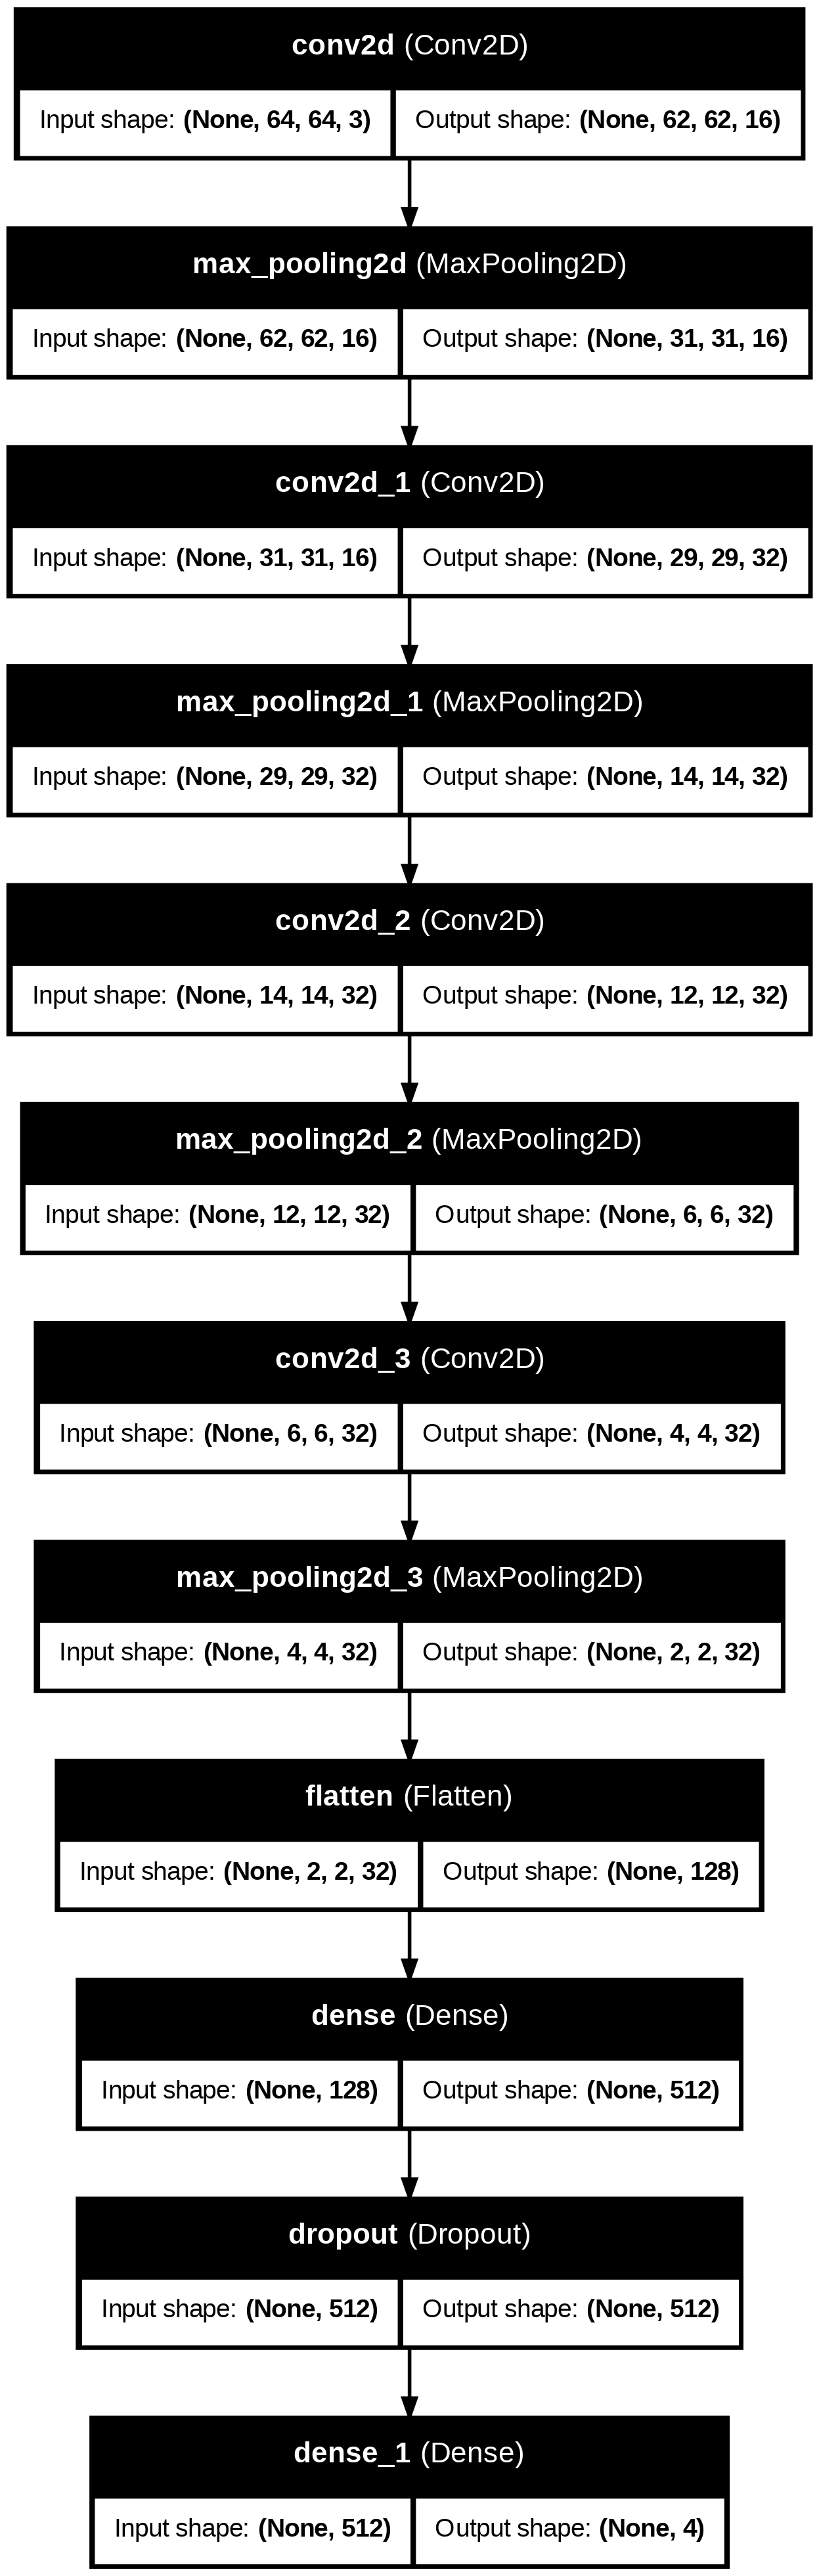

In [ ]:
from tensorflow.keras.utils import plot_model

# Save and display the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# You can download the 'model_architecture.png' file to include it in your paper.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Predictions
predictions = model.predict(validation_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(validation_labels, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(validation_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Binarize the true labels for multi-class ROC curve
true_classes_bin = label_binarize(true_classes, classes=np.arange(len(class_names)))

# Initialize the plot
plt.figure(figsize=(10, 8))

# Calculate and plot the ROC curve for each class
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# Plot random chance line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Customize the plot
plt.title('ROC Curve for Multi-class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#saving model
model.save('alzheimers_detection_model.keras')
print("Model saved as alzheimers_detection_model.keras")


Model saved as alzheimers_detection_model.keras
